# Occupation-skills matrix differentiating between essential and optional skills
Felix Zaussinger | 30.07.2021

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper", font_scale=1.5)
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [3]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))
skills_hierarchy = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.8", "skillsHierarchy_en.csv"))

skills_hierarchy_kanders = pd.read_csv(os.path.join(data_raw, "mcc_data", "processed", "ESCO_skills_hierarchy", "ESCO_skills_hierarchy.csv"))

### Build occupation - skills matrix

**Encoding**
- 0: skill not required
- 1: skill required, essential
- 2: skill required, optional

In [4]:
run = False

if run:
    errors = 0
    skill_vectors = []

    for i in tqdm(range(len(occ))):
        occ_uri = occ.iloc[i, :][1]

        # lookup corresponding skills
        skill_list = occ_skills_mapping[occ_skills_mapping["occupationUri"] == occ_uri]

        # create vector
        skill_vector = []
        for j, skill in enumerate(skills.conceptUri.values):

            if skill in skill_list.skillUri.values:
                relation_type = skill_list.loc[skill_list.skillUri == skill, "relationType"].values[0]

                # skill needed for occupation and essential
                if relation_type == "essential":
                    skill_vector.append(1)
                # skill needed for occupation and optional
                elif relation_type == "optional":
                    skill_vector.append(2)
            else:
                # skill not needed for occupation
                skill_vector.append(0)

        indices = [i for i, j in enumerate(skill_vector) if j == 1]

        # sanity check
        if len(skill_list.skillUri) != np.sum(np.invert(np.array(skill_vector) == 0)):
            errors += 1

        # append
        skill_vectors.append(skill_vector)

    # info
    print("n_errors: ", errors)

    # create df
    occ_skills_matrix = pd.DataFrame(
        index=occ.conceptUri,
        columns=skills.conceptUri,
        data=np.array(skill_vectors)
    )

    # save
    occ_skills_matrix.to_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
    )
else:
    occ_skills_matrix = pd.read_pickle(
        os.path.join(project_dir, "data", "processed", "adjacency_matrix_essential_optional.pkl")
    )

    # weights: essential = 1, optional = 0.5
    occ_skills_matrix = occ_skills_matrix.replace(to_replace=2, value=0.5)

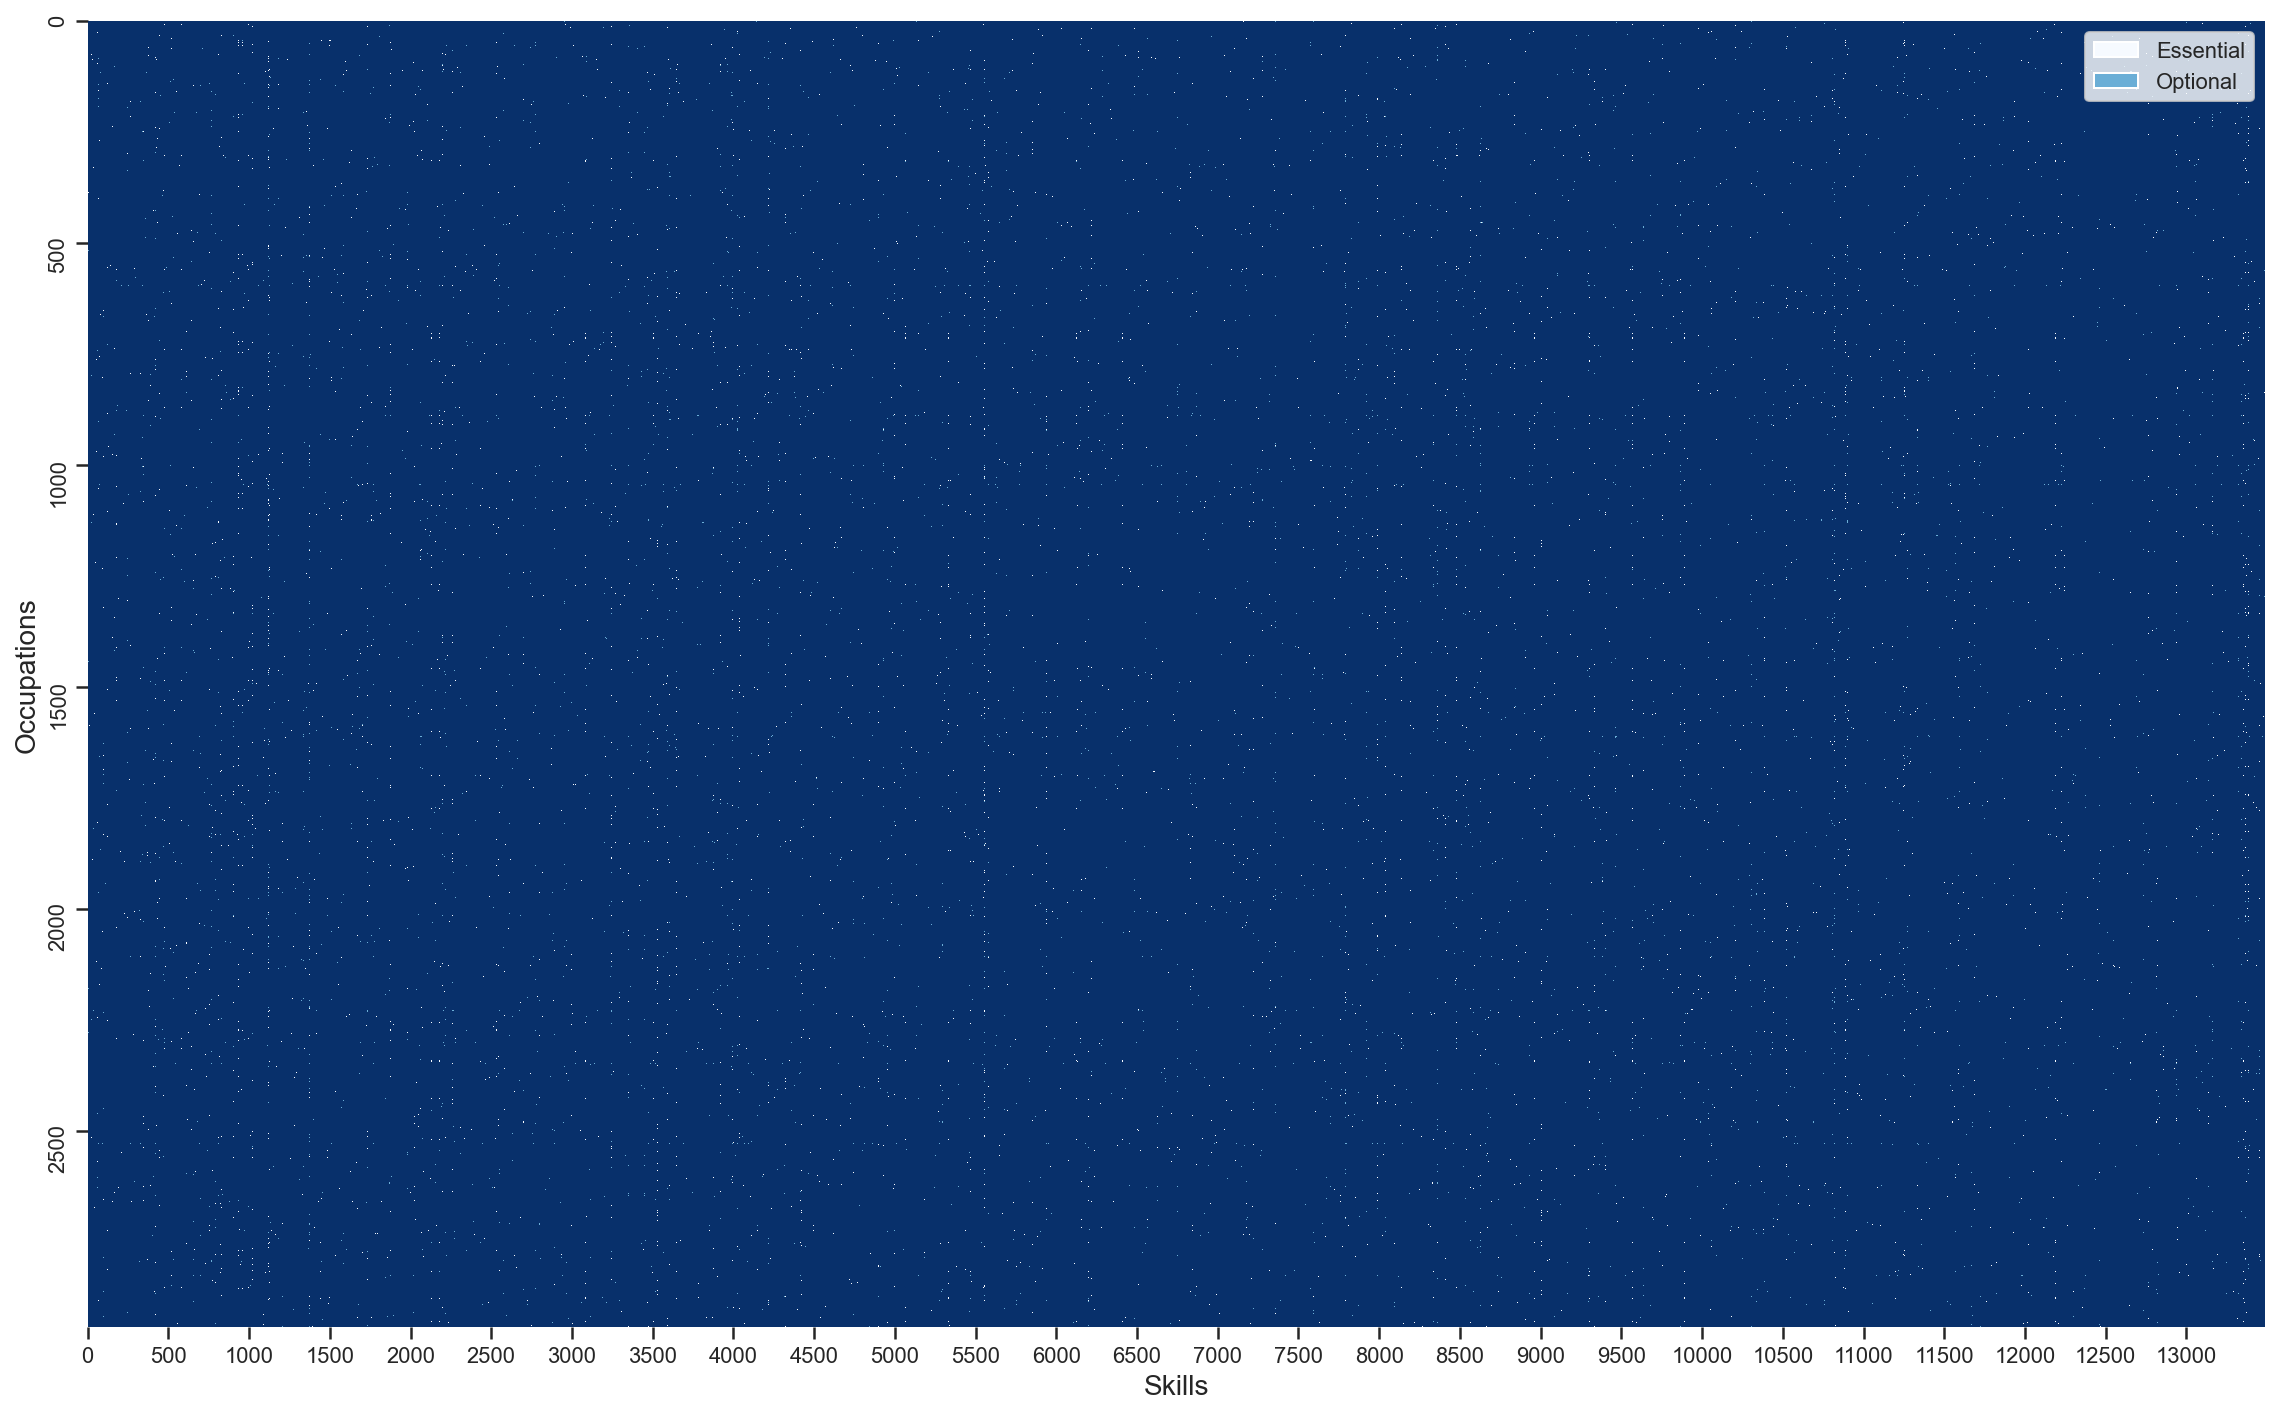

In [5]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(16,10))

cmap = plt.get_cmap('Blues_r', 3)
cmap2 = plt.get_cmap('Blues')

sns.heatmap(
    data=occ_skills_matrix.values,
    cmap=cmap,
    xticklabels=500,
    yticklabels=500,
    ax=ax,
    cbar=False
)

plt.xlabel('Skills', fontsize=14)
plt.ylabel('Occupations', fontsize=14)

legend_elements = [Patch(facecolor=cmap2(1), label='Essential', edgecolor=None),
                   Patch(facecolor=cmap2(0.5), label='Optional', edgecolor=None)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_skills_matrix.png"),
    bbox_inches="tight",
    dpi=150
)

In [6]:
# reindex by isco level
reindex_by_isco4 = occ.sort_values("iscoGroup").index.values

# reindex by skills hierarchy
assert np.alltrue(skills_hierarchy_kanders.concept_uri == skills.conceptUri)
sorted(skills_hierarchy_kanders.level_1.dropna().unique())
reindex_by_skills_hierarchy = skills_hierarchy_kanders.sort_values("level_2").index.values

In [7]:
occ_skills_matrix_ordered = occ_skills_matrix.values[reindex_by_isco4, :]
occ_skills_matrix_ordered = occ_skills_matrix.values[:, reindex_by_skills_hierarchy]
occ_skills_matrix_ordered[occ_skills_matrix_ordered == 0] = np.nan

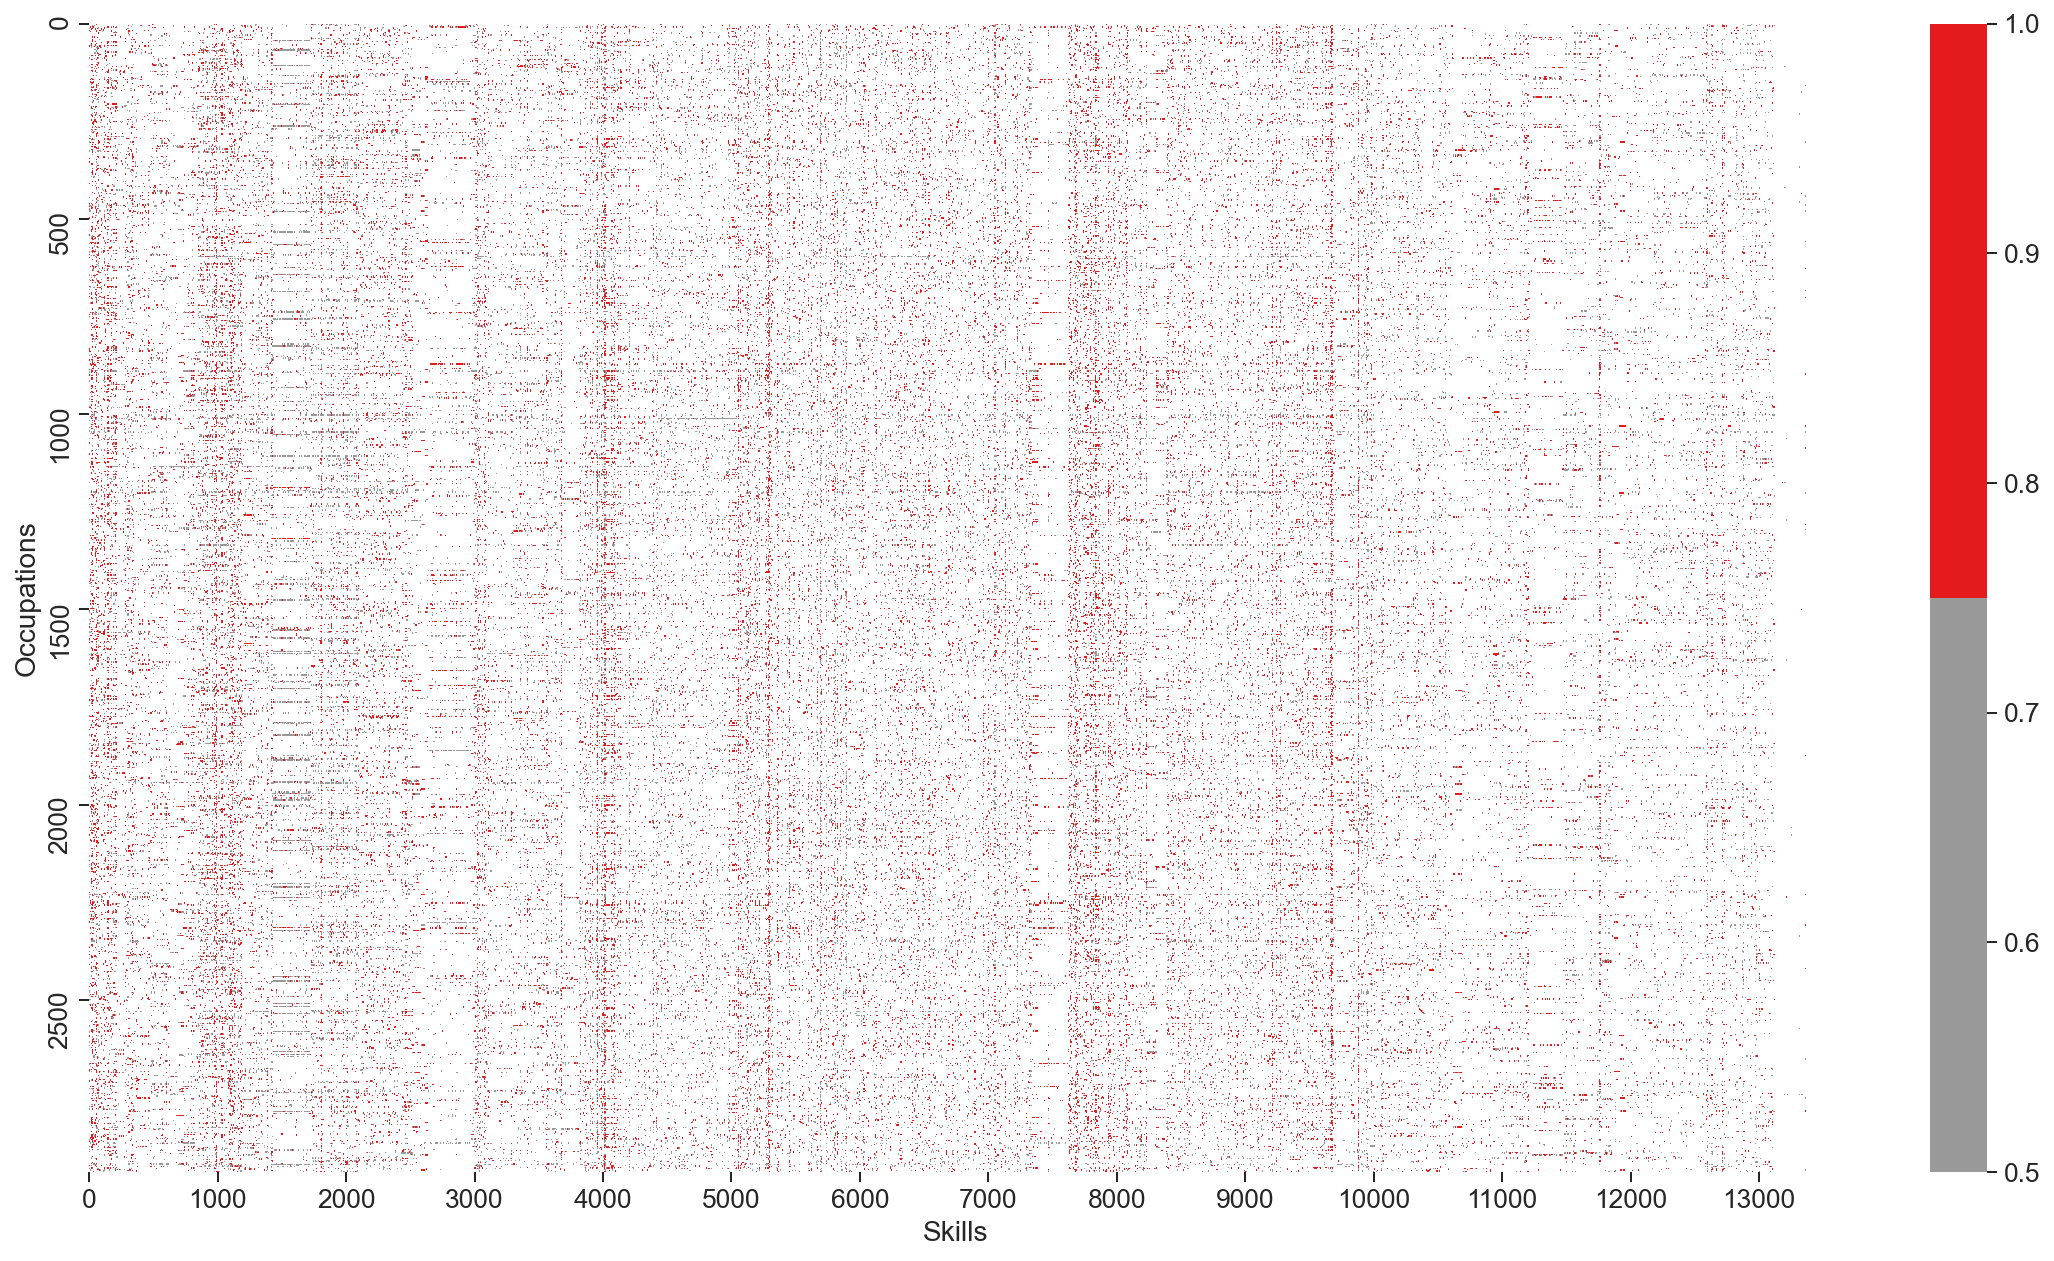

In [30]:
with sns.axes_style("ticks"), sns.plotting_context("paper", font_scale=1.5):
    ax = sns.heatmap(
        data=occ_skills_matrix_ordered,
        cmap=plt.get_cmap("Set1_r", 2),
        xticklabels=1000,
        yticklabels=500,
        cbar=True
    )

    plt.xlabel('Skills', fontsize=14)
    plt.ylabel('Occupations', fontsize=14)

    plt.tight_layout()

    plt.savefig(
        os.path.join(figure_dir, "esco", "occupation_skills_matrix_v2.png"),
        bbox_inches="tight",
        dpi=300
    )

In [9]:
occ_sim_matrix = np.dot(
    occ_skills_matrix.values,
    occ_skills_matrix.values.transpose()
)

In [10]:
df_sim_upeksha = pd.read_csv(
    os.path.join(data_processed, "occupation_adjacency_upeksha.csv"),
    index_col=0
)

In [11]:
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

In [12]:
np.corrcoef(occ_sim_matrix.flatten(), df_sim_upeksha.values.flatten())
np.corrcoef(occ_sim_matrix.flatten(), sim_kanders.flatten())

array([[1.        , 0.64141025],
       [0.64141025, 1.        ]])

In [13]:
from scipy.stats import pearsonr

pearsonr(occ_sim_matrix.flatten(), sim_kanders.flatten())

(0.6414102460093973, 0.0)

In [14]:
# the matrices are pretty similar, but not exactly the same
comp = occ_sim_matrix == df_sim_upeksha.values
np.unique(comp, return_counts=True)

(array([False,  True]), array([    932, 8654432]))

In [15]:
occ_sim_matrix.mean()

0.42023238421861864

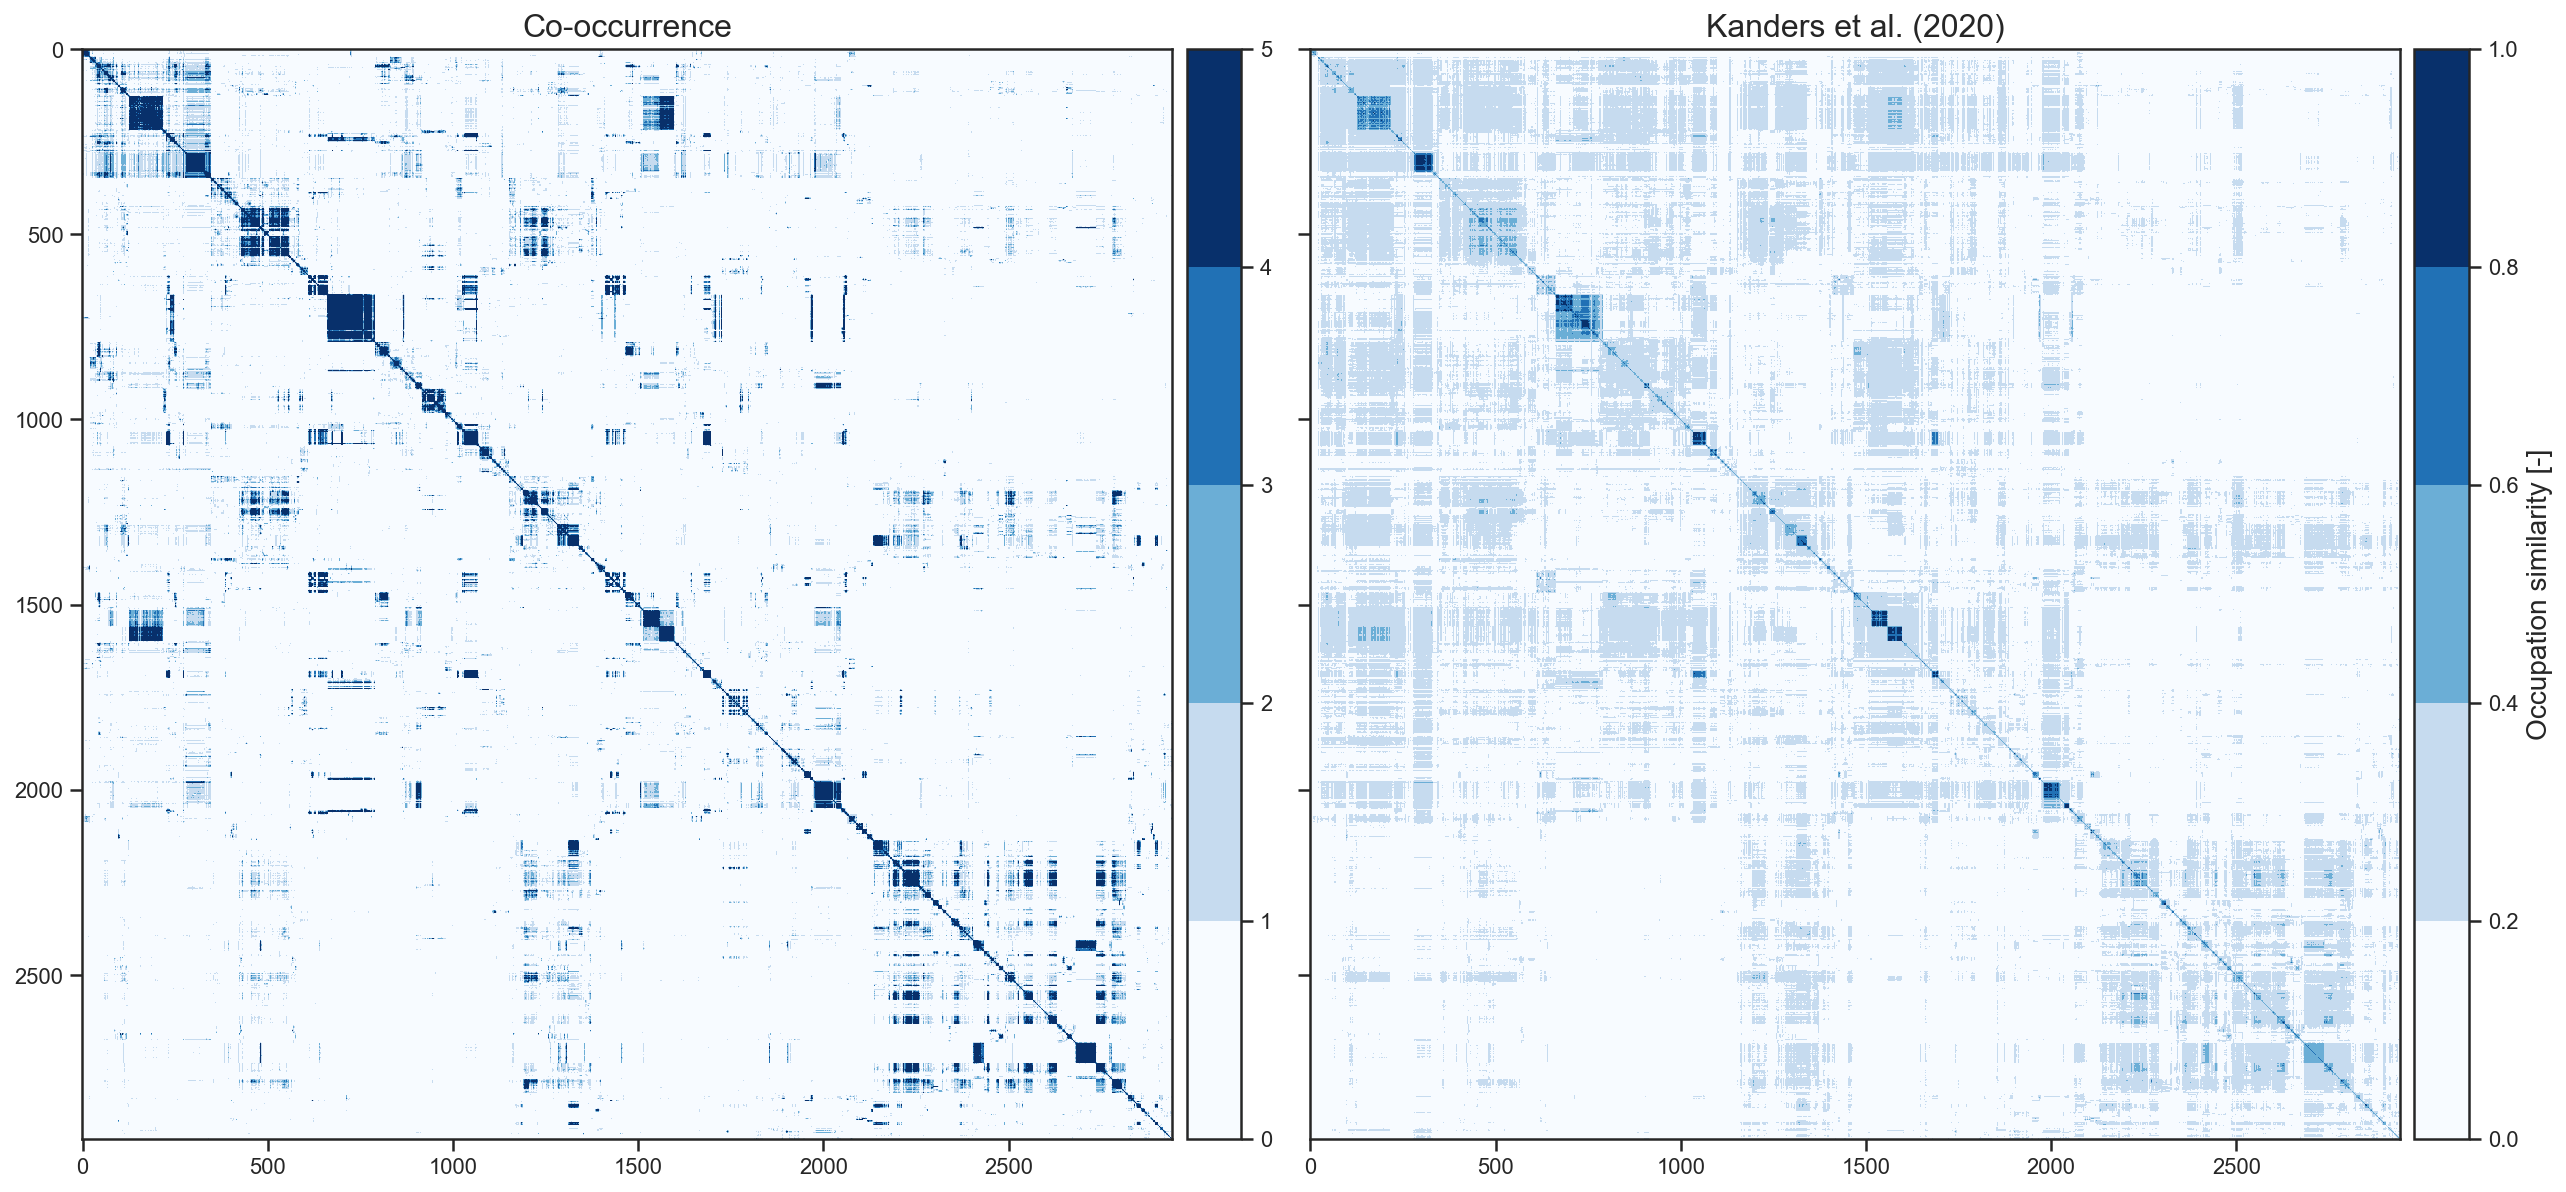

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 9), sharey=True, sharex=True)

# reindex by isco level
reindex_by_isco4 = occ.sort_values("iscoGroup").index.values
x, y = np.meshgrid(reindex_by_isco4, reindex_by_isco4)

# define cmap
cmap = plt.get_cmap("Blues", 5)

# ax1
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.1)

im = ax1.imshow(occ_sim_matrix[x, y], cmap = cmap, vmin=0, vmax=5)
ax1.set_title('Co-occurrence', fontsize=16)
fig.colorbar(im, cax=cax1, fraction=0.046, pad=0.04, orientation='vertical')

# ax2
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.1)

im = ax2.imshow(sim_kanders[x, y], cmap = cmap, vmin=0, vmax=1)
ax2.set_title('Kanders et al. (2020)', fontsize=16)
fig.colorbar(im, cax=cax2, fraction=0.046, pad=0.04, orientation='vertical')

plt.ylabel('Occupation similarity [-]', fontsize=14)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix.png"),
    bbox_inches="tight",
    dpi=300
)

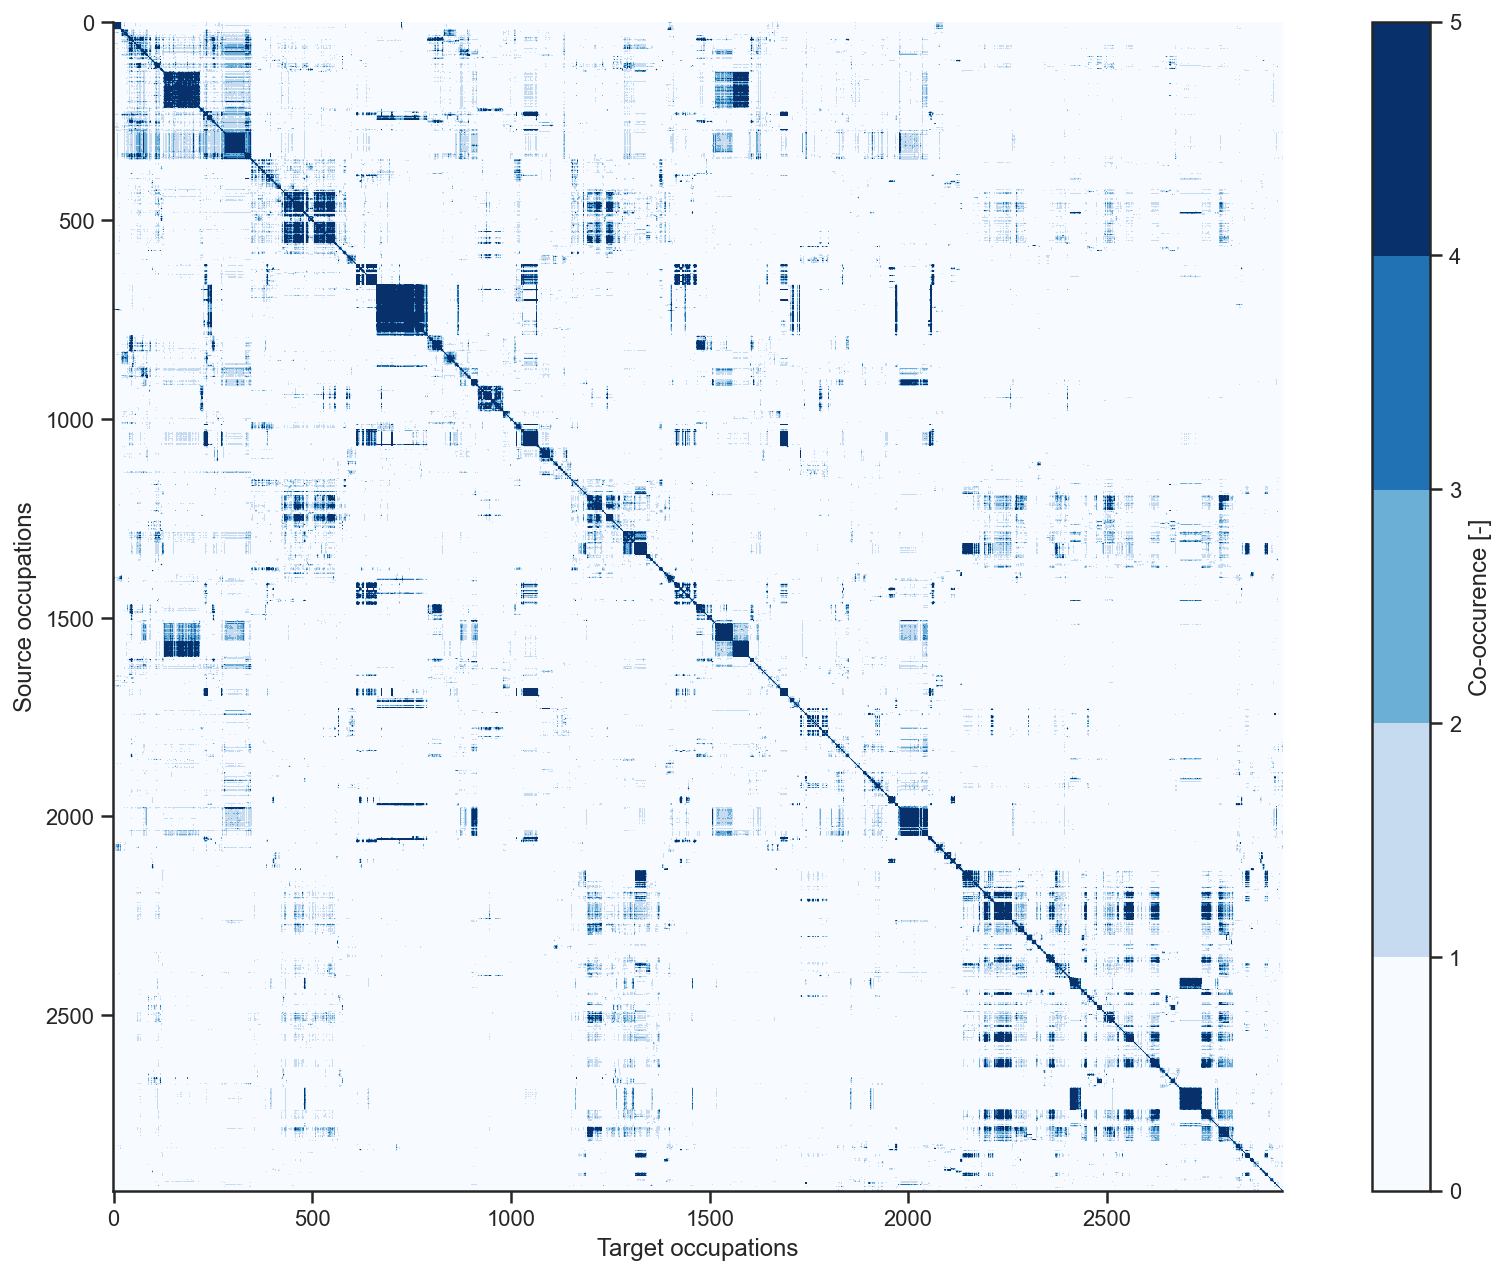

In [17]:
# reindex by isco level
reindex_by_isco4 = occ.sort_values("iscoGroup").index.values
x, y = np.meshgrid(reindex_by_isco4, reindex_by_isco4)

# define cmap
cmap = plt.get_cmap("Blues", 5)

plt.imshow(occ_sim_matrix[x, y], cmap = cmap, vmin=0, vmax=5)
cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical')
cbar.ax.set_ylabel("Co-occurence [-]")
plt.xlabel("Target occupations")
plt.ylabel("Source occupations")

plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix_cooc.png"),
    bbox_inches="tight",
    dpi=300
)

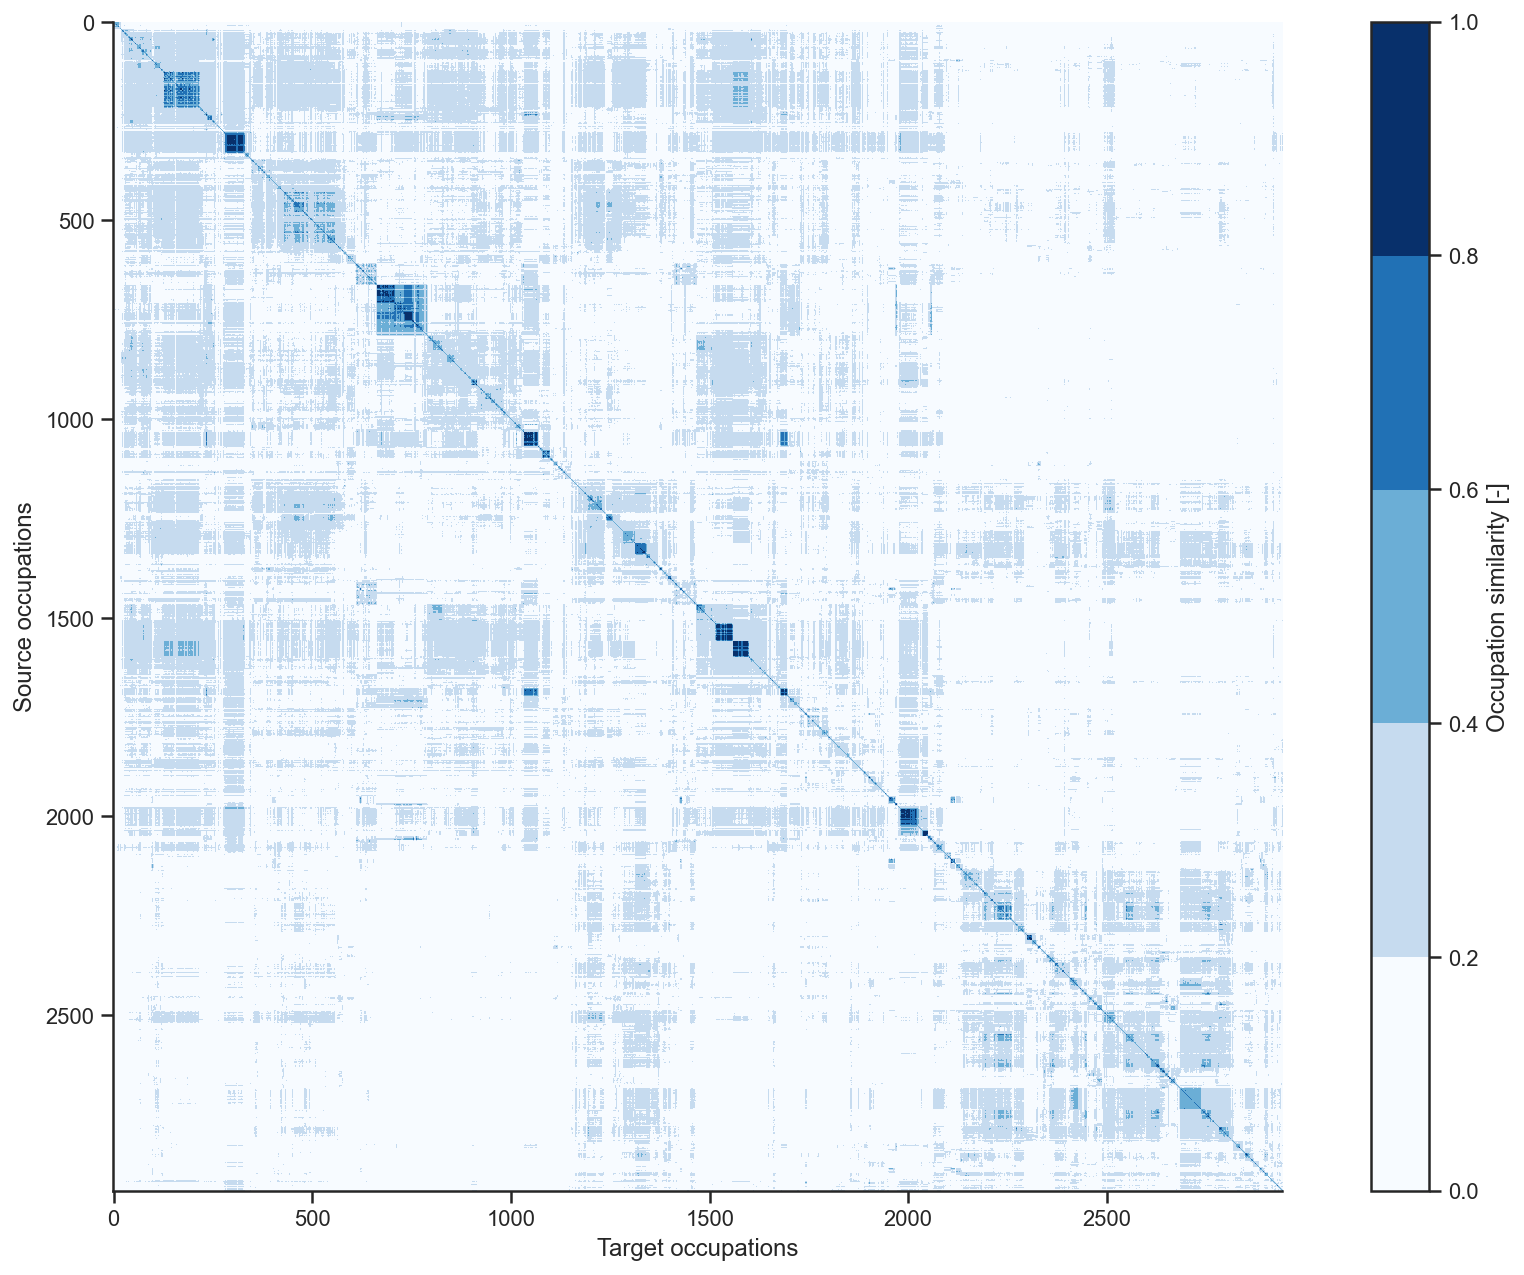

In [18]:
plt.imshow(sim_kanders[x, y], cmap = cmap, vmin=0, vmax=1)
cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical')
cbar.ax.set_ylabel("Occupation similarity [-]")
plt.xlabel("Target occupations")
plt.ylabel("Source occupations")
plt.tight_layout()
sns.despine()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix_kanders.png"),
    bbox_inches="tight",
    dpi=300
)

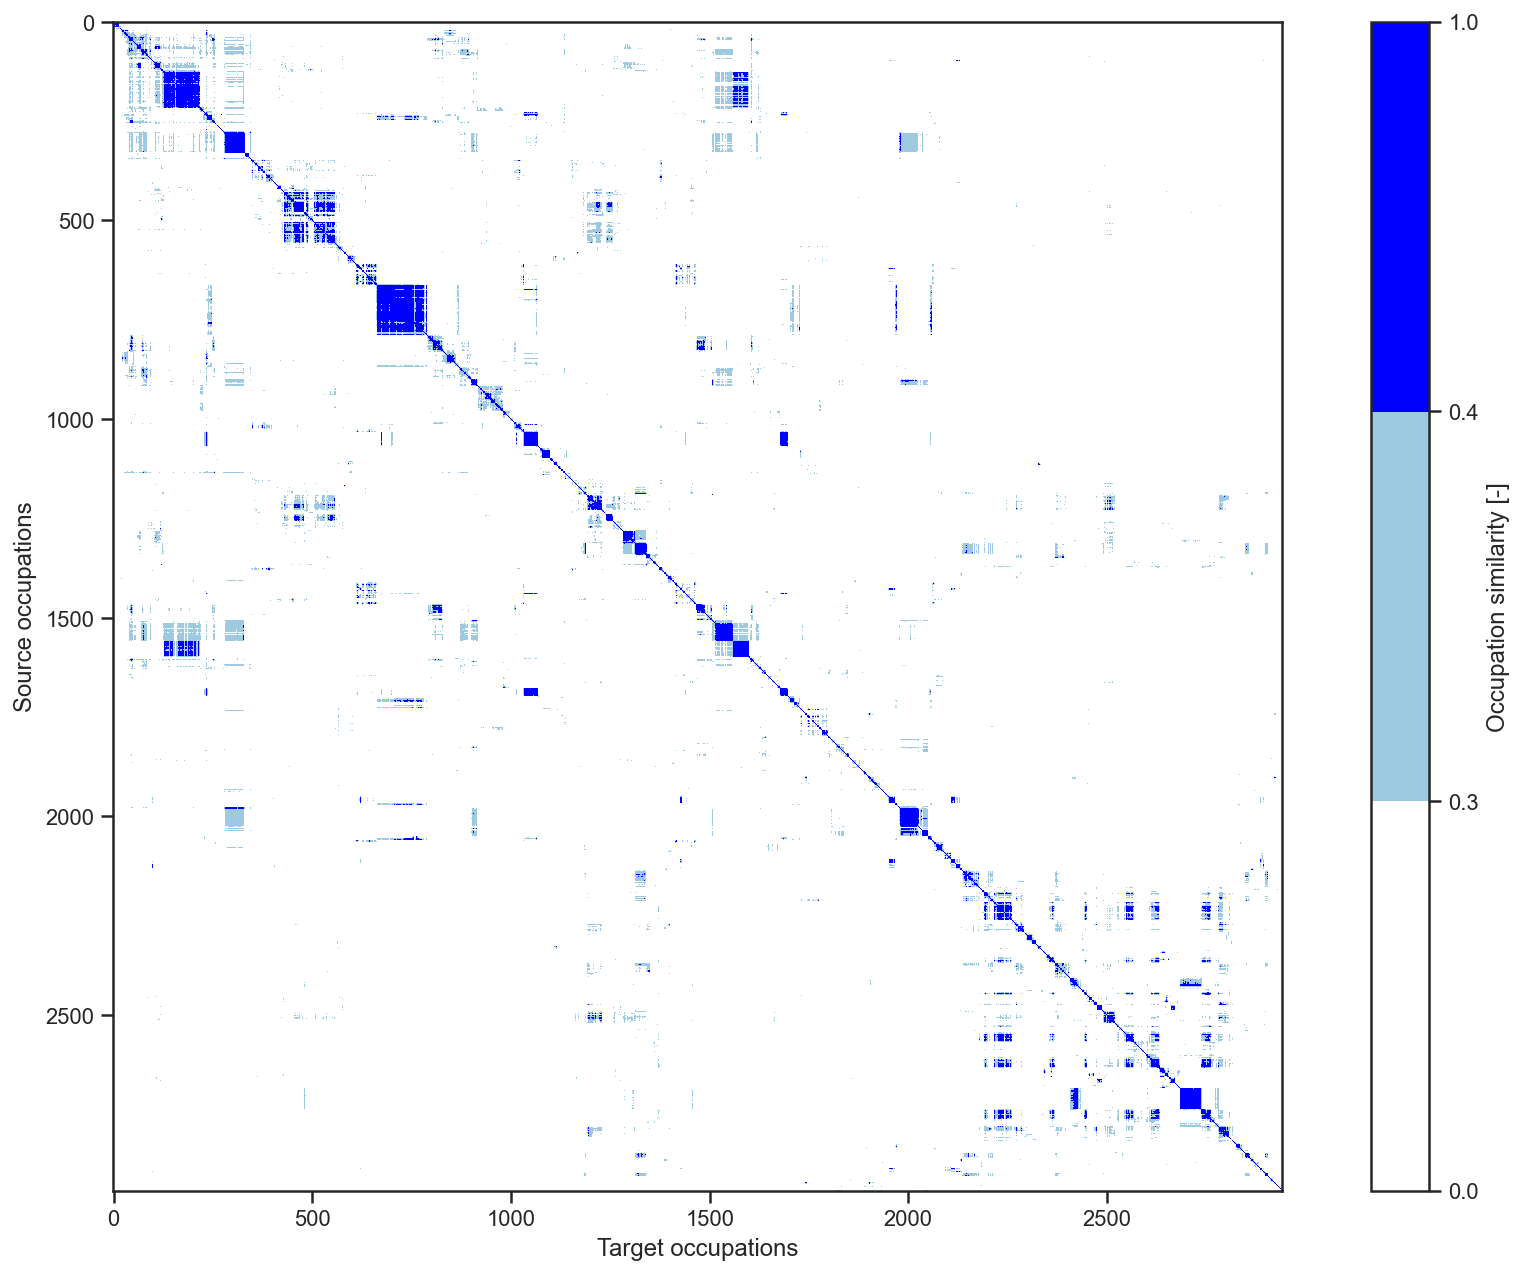

In [19]:
# viable/desirable classification

# make a color map of fixed colors ['white', '#9ecae1', '#08519']
cmap_classified = mpl.colors.ListedColormap(['white', '#9ecae1', '#9ecae1', 'blue'])
bounds =[0, 0.3, 0.4, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(sim_kanders[x, y], cmap = cmap_classified, norm=norm)
cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical', boundaries=bounds, ticks=bounds)
cbar.ax.set_ylabel("Occupation similarity [-]")
plt.xlabel("Target occupations")
plt.ylabel("Source occupations")
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix_kanders_classified.png"),
    bbox_inches="tight",
    dpi=300
)

#### Indicate ISCO major groups

In [20]:
rdict = {110: 0000, 210: 0000, 310: 0000}
reindex_isco_lvl1 = occ.sort_values("iscoGroup").iscoGroup.replace(rdict).astype(str).str.slice(0, 1).astype(int)
df_reindex_isco_lvl1 = reindex_isco_lvl1.diff().reset_index()
df_reindex_isco_lvl1

,index,iscoGroup
0,2215,NaN
1,1418,0.0
2,1864,0.0
3,2787,0.0
4,2659,0.0
...,...,...
2937,2629,0.0
2938,2645,0.0
2939,377,0.0
2940,463,0.0


In [21]:
isco_lvl1_mapping = {
    0: "Military",
    1: "Managers",
    2: "Professionals",
    3: "Technicians and\nassociate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural,\nforestry and fishery workers",
    7: "Craft and\nrelated trades workers",
    8: "Plant and machine\noperators and assemblers",
    9: "Elementary occupations"
}

lvl1_boundaries = df_reindex_isco_lvl1.loc[df_reindex_isco_lvl1.iscoGroup == 1]
tick_locs = np.insert(lvl1_boundaries.index.values, [0, 9], [0, 2942])
tick_locs

array([   0,   21,  348, 1152, 1799, 1887, 2091, 2136, 2521, 2868, 2942])

In [22]:
center_ticks = []
for i in range(len(tick_locs) - 1):
    c = (tick_locs[i] + tick_locs[i+1]) / 2
    center_ticks.append(c)

center_ticks

[10.5, 184.5, 750.0, 1475.5, 1843.0, 1989.0, 2113.5, 2328.5, 2694.5, 2905.0]

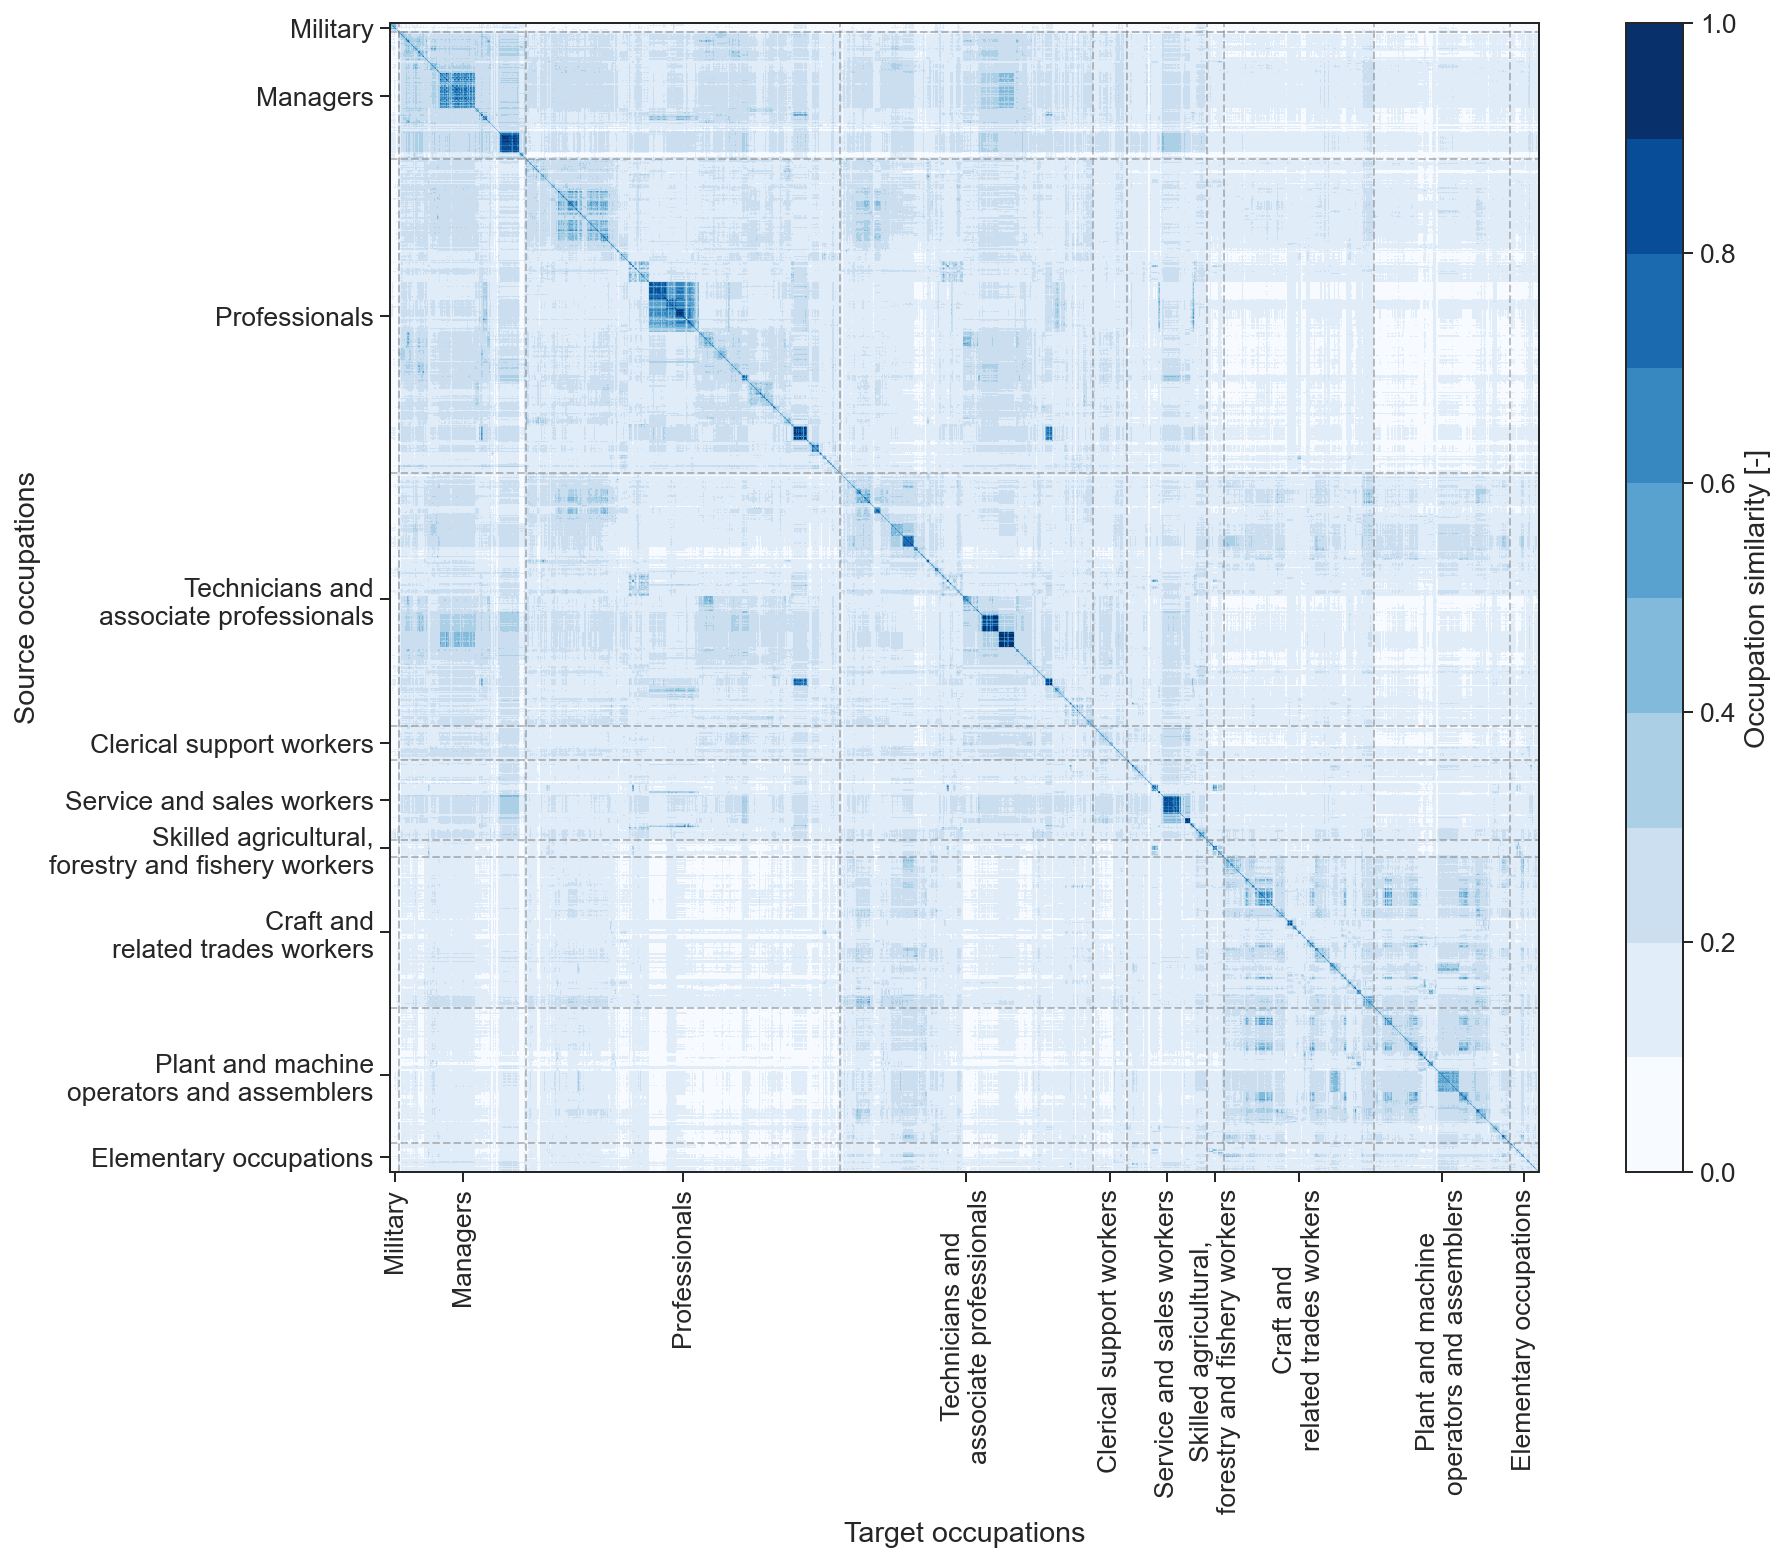

In [27]:
with sns.axes_style("ticks"), sns.plotting_context("paper", font_scale=1.5):
    plt.imshow(sim_kanders[x, y], cmap = plt.get_cmap("Blues", 10), vmin=0, vmax=1)
    cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical')
    cbar.ax.set_ylabel("Occupation similarity [-]")
    plt.xlabel("Target occupations")
    plt.ylabel("Source occupations")
    plt.tight_layout()
    #sns.despine()

    plt.xticks(center_ticks, list(isco_lvl1_mapping.values()), rotation=90)
    plt.yticks(center_ticks, list(isco_lvl1_mapping.values()))

    for i in df_reindex_isco_lvl1.index.values:
        if df_reindex_isco_lvl1.loc[i, "iscoGroup"] == 1:
            plt.axvline(x=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")
            plt.axhline(y=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")


    plt.savefig(
        os.path.join(figure_dir, "esco", "occupation_similarity_matrix_kanders_isco_groups.png"),
        bbox_inches="tight",
        dpi=300
    )

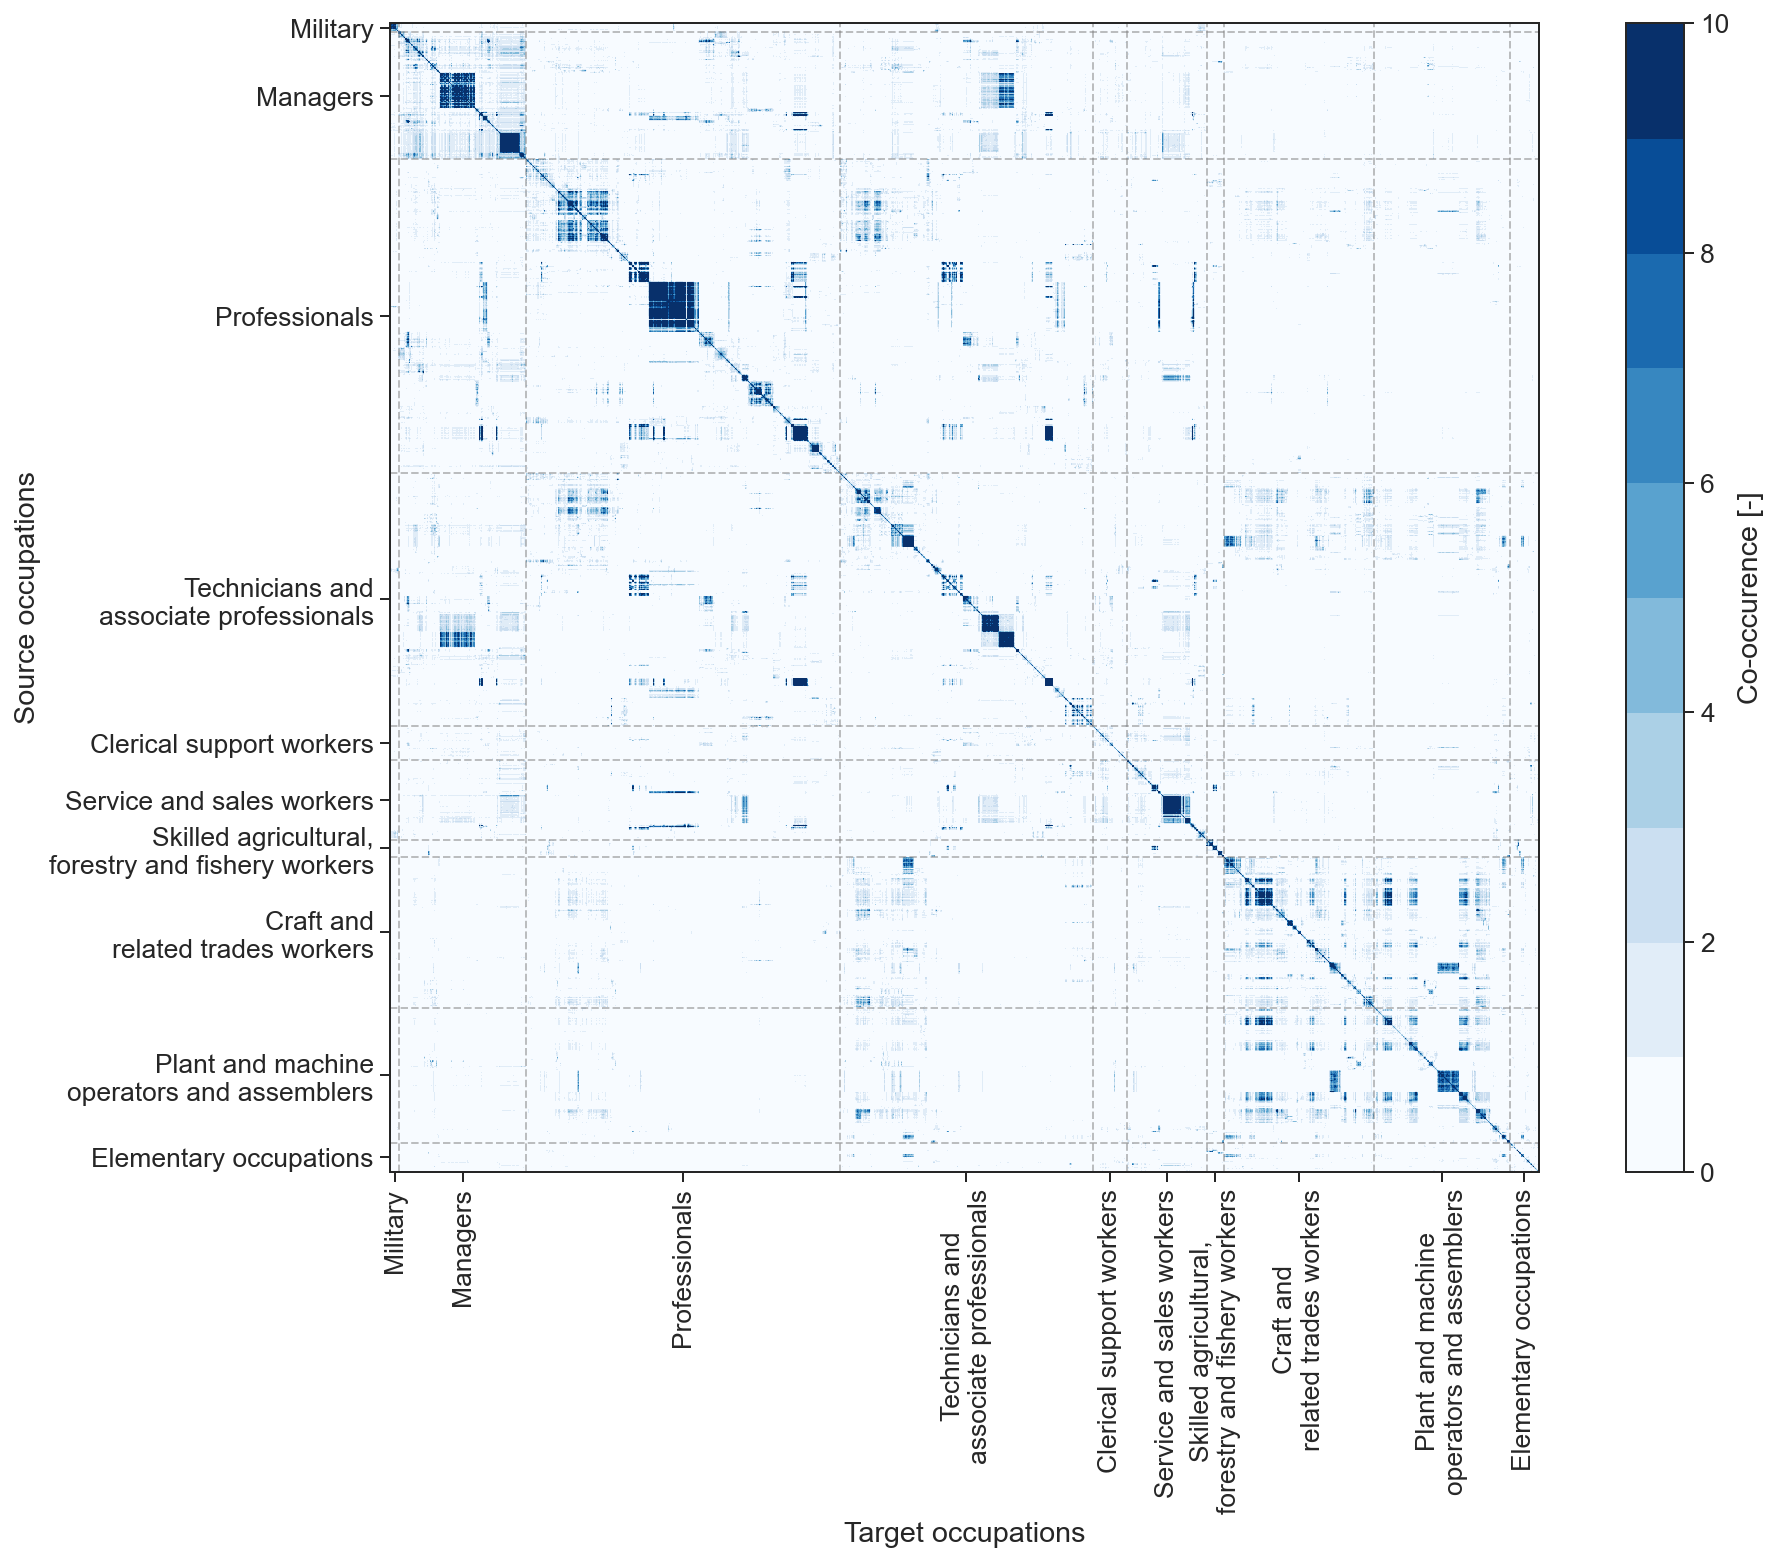

In [28]:
with sns.axes_style("ticks"), sns.plotting_context("paper", font_scale=1.5):
    plt.imshow(occ_sim_matrix[x, y], cmap = plt.get_cmap("Blues", 10), vmin=0, vmax=10)
    cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical')
    cbar.ax.set_ylabel("Co-occurence [-]")
    plt.xlabel("Target occupations")
    plt.ylabel("Source occupations")
    plt.tight_layout()
    #sns.despine()

    plt.xticks(center_ticks, list(isco_lvl1_mapping.values()), rotation=90)
    plt.yticks(center_ticks, list(isco_lvl1_mapping.values()))

    for i in df_reindex_isco_lvl1.index.values:
        if df_reindex_isco_lvl1.loc[i, "iscoGroup"] == 1:
            plt.axvline(x=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")
            plt.axhline(y=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")


    plt.savefig(
        os.path.join(figure_dir, "esco", "occupation_similarity_matrix_cooc_isco_groups.png"),
        bbox_inches="tight",
        dpi=300
    )

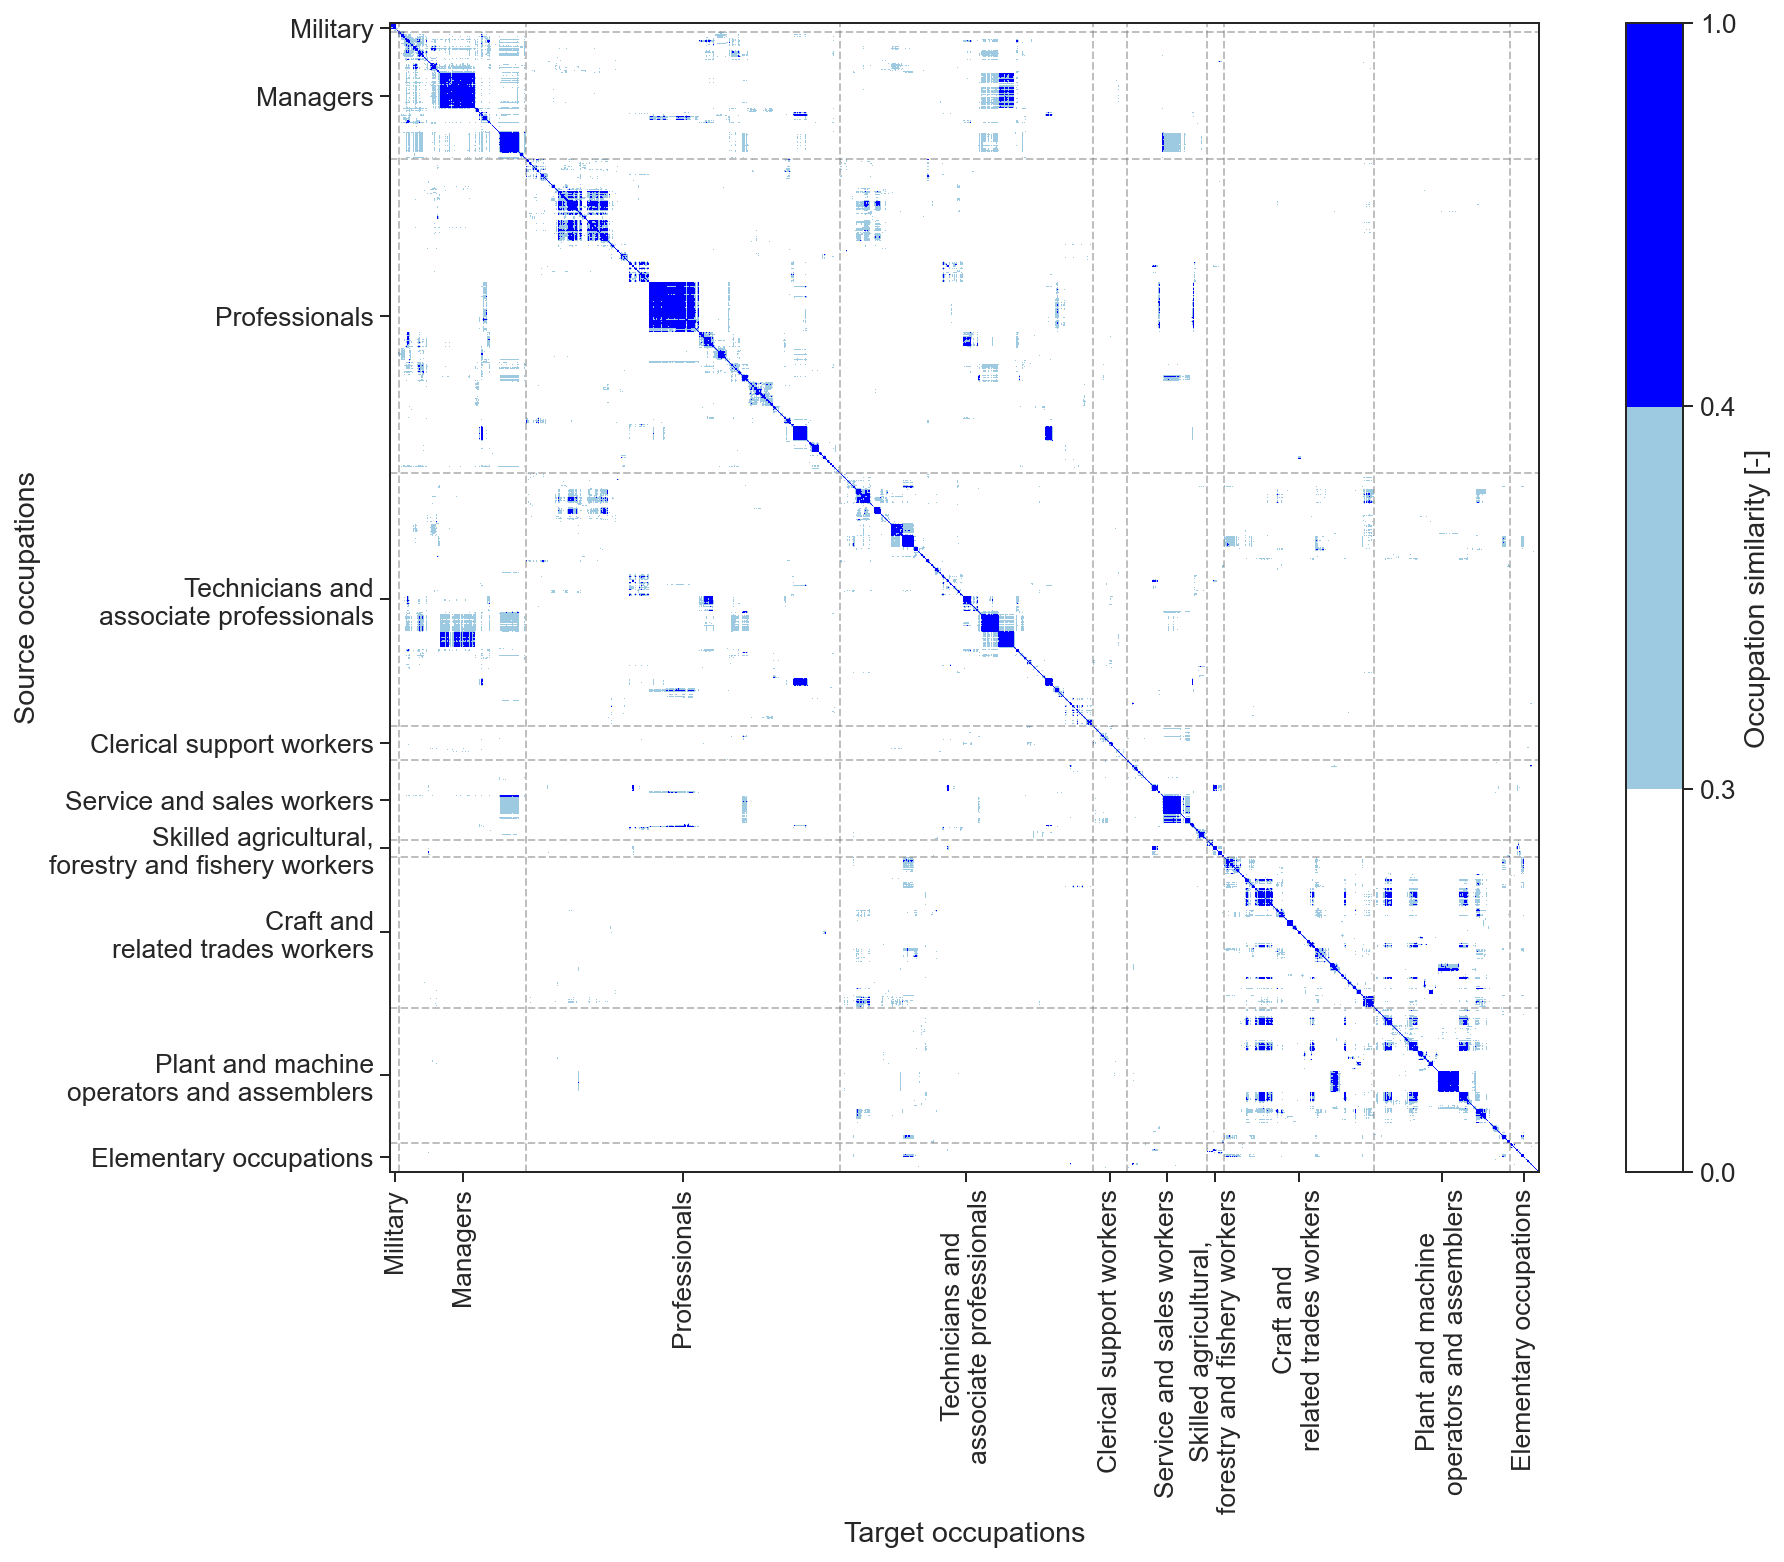

In [29]:
# classified with isco groups
cmap_classified = mpl.colors.ListedColormap(['white', '#9ecae1', '#9ecae1', 'blue'])
bounds =[0, 0.3, 0.4, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

with sns.axes_style("ticks"), sns.plotting_context("paper", font_scale=1.5):
    plt.imshow(sim_kanders[x, y], cmap = cmap_classified, norm=norm)
    cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical', boundaries=bounds, ticks=bounds)
    cbar.ax.set_ylabel("Occupation similarity [-]")
    plt.xlabel("Target occupations")
    plt.ylabel("Source occupations")
    plt.tight_layout()

    plt.xticks(center_ticks, list(isco_lvl1_mapping.values()), rotation=90)
    plt.yticks(center_ticks, list(isco_lvl1_mapping.values()))

    for i in df_reindex_isco_lvl1.index.values:
        if df_reindex_isco_lvl1.loc[i, "iscoGroup"] == 1:
            plt.axvline(x=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")
            plt.axhline(y=i, color='grey', linewidth=1, alpha=0.5, linestyle="--")

    plt.savefig(
        os.path.join(figure_dir, "esco", "occupation_similarity_matrix_kanders_classified_isco_groups.png"),
        bbox_inches="tight",
        dpi=300
    )

In [ ]:
# ax2
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.1)

im = ax2.imshow(sim_kanders[x, y], cmap = cmap, vmin=0, vmax=1)
ax2.set_title('Kanders et al. (2020)', fontsize=16)
fig.colorbar(im, cax=cax2, fraction=0.046, pad=0.04, orientation='vertical')

plt.ylabel('Occupation similarity [-]', fontsize=14)

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "occupation_similarity_matrix_rows.png"),
    bbox_inches="tight",
    dpi=300
)

### Construct skills similarity matrix
- based on scipy sparse class

In [ ]:
from scipy.sparse import csr_matrix

occ_skills_matrix_eo_sparse = csr_matrix(occ_skills_matrix.values)
skill_sim_matrix_eo_sparse = occ_skills_matrix_eo_sparse.transpose().dot(occ_skills_matrix_eo_sparse)
skill_sim_matrix_eo = skill_sim_matrix_eo_sparse.toarray()
skill_sim_matrix_eo.tofile(os.path.join(data_processed, "skill_sim_matrix_eo.npy"))

In [ ]:
occ_skills_matrix_unw = occ_skills_matrix.replace(to_replace=0.5, value=1.0)
occ_skills_matrix_unw_sparse = csr_matrix(occ_skills_matrix_unw.values)
skill_sim_matrix_unw_sparse = occ_skills_matrix_unw_sparse.transpose().dot(occ_skills_matrix_unw_sparse)
skill_sim_matrix_unw = skill_sim_matrix_unw_sparse.toarray()
skill_sim_matrix_unw.tofile(os.path.join(data_processed, "skill_sim_matrix.npy"))

In [ ]:
xs, ys = np.meshgrid(reindex_by_skills_hierarchy, reindex_by_skills_hierarchy)
skill_sim_matrix_unw_sorted = skill_sim_matrix_unw[xs, ys]

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = plt.get_cmap('Blues', 3)

plt.imshow(skill_sim_matrix_unw_sorted, cmap = cmap, vmax=3)
cbar = plt.colorbar(fraction=0.046, pad=0.04, orientation='vertical')
cbar.ax.set_ylabel("Skills co-occurence [-]")
plt.xlabel("Skills")
plt.ylabel("Skills")
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "esco", "skills_skills_matrix_v2.png"),
    bbox_inches="tight",
    dpi=150
)